# Decision Trees vs Random Forrest

	1.	Carga tu CSV.
	2.	Crea el target binario HighSalary (≥ p75).
	3.	Divide en train/test.
	4.	Preprocesa (One-Hot para categóricas).
	5.	Entrena Decision Tree y Random Forest.
	6.	Calcula accuracy, precision, recall, F1, AUC, matriz de confusión y curva ROC.


In [13]:
# ===================== Librerías =====================

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)



In [5]:
# ===================== 1) CARGA =====================
DATA_PATH = Path("/Users/sultan/DataScience/Classification/data_Trees_RandomForrest.csv")
df = pd.read_csv(DATA_PATH)

# Normalizamos nombres para el pipeline (sin tocar tu CSV original)
df = df.rename(columns={
    "Estado Civil": "EstadoCivil",
    "Nivel educativo": "NivelEducativo",
    "Región": "Region"
})

# Verificación mínima
esperadas = {"Edad","Sexo","EstadoCivil","NivelEducativo","Region","Salario"}
faltan = esperadas - set(df.columns)
if faltan:
    raise ValueError(f"Faltan columnas: {faltan}. Columnas presentes: {list(df.columns)}")



In [6]:
# ===================== 2) TARGET BINARIO =====================
# HighSalary = 1 si Salario >= p75, 0 en caso contrario
p75 = df["Salario"].quantile(0.75)
df["HighSalary"] = (df["Salario"] >= p75).astype(int)

X = df[["Edad","Sexo","EstadoCivil","NivelEducativo","Region"]]
y = df["HighSalary"]



In [7]:
# ===================== 3) SPLIT =====================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=123, stratify=y
)



In [8]:
# ===================== 4) PREPROCESO =====================
num_cols = ["Edad"]
cat_cols = ["Sexo","EstadoCivil","NivelEducativo","Region"]

preprocess = ColumnTransformer([
    ("num", "passthrough", num_cols),
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
])



In [10]:
# ===================== 5) MODELOS =====================
dt = Pipeline([
    ("prep", preprocess),
    ("model", DecisionTreeClassifier(random_state=123))
])

rf = Pipeline([
    ("prep", preprocess),
    ("model", RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=123))
])

dt.fit(X_train, y_train)
rf.fit(X_train, y_train)



,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [11]:
# ===================== 6) MÉTRICAS =====================
def eval_model(pipe, X_te, y_te, name):
    yhat = pipe.predict(X_te)
    yproba = pipe.predict_proba(X_te)[:,1]
    metrics = {
        "model": name,
        "accuracy": accuracy_score(y_te, yhat),
        "precision": precision_score(y_te, yhat, zero_division=0),
        "recall": recall_score(y_te, yhat, zero_division=0),
        "f1": f1_score(y_te, yhat, zero_division=0),
        "auc": roc_auc_score(y_te, yproba),
        "cm": confusion_matrix(y_te, yhat),
        "roc": roc_curve(y_te, yproba)
    }
    return metrics

dt_m = eval_model(dt, X_test, y_test, "DecisionTree")
rf_m = eval_model(rf, X_test, y_test, "RandomForest")

print(f"HighSalary threshold (p75): {p75:.2f}\n")
for m in [dt_m, rf_m]:
    print(f"=== {m['model']} ===")
    print(f"Accuracy : {m['accuracy']:.3f}")
    print(f"Precision: {m['precision']:.3f}")
    print(f"Recall   : {m['recall']:.3f}")
    print(f"F1       : {m['f1']:.3f}")
    print(f"AUC      : {m['auc']:.3f}")
    print("Confusion matrix:\n", m["cm"], "\n")



HighSalary threshold (p75): 1621.88

=== DecisionTree ===
Accuracy : 0.912
Precision: 0.885
Recall   : 0.742
F1       : 0.807
AUC      : 0.886
Confusion matrix:
 [[91  3]
 [ 8 23]] 

=== RandomForest ===
Accuracy : 0.944
Precision: 0.929
Recall   : 0.839
F1       : 0.881
AUC      : 0.977
Confusion matrix:
 [[92  2]
 [ 5 26]] 



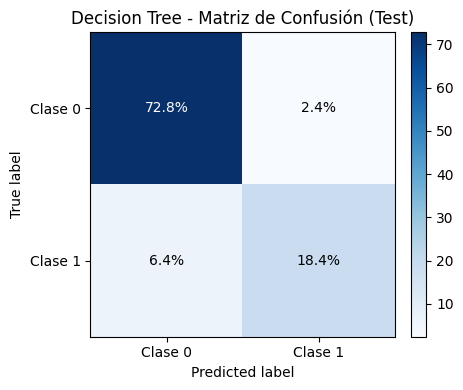

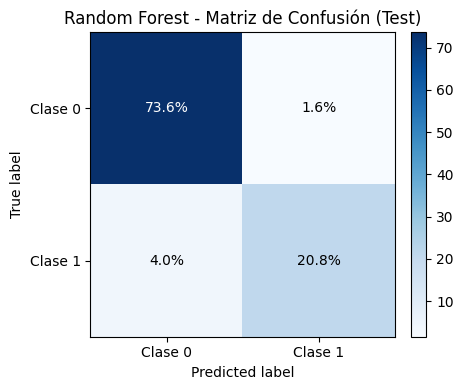

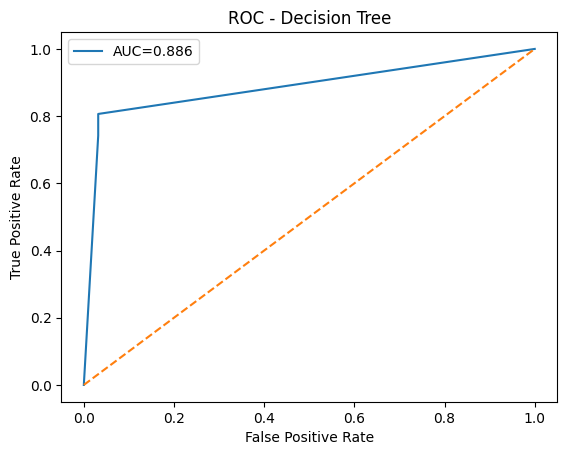

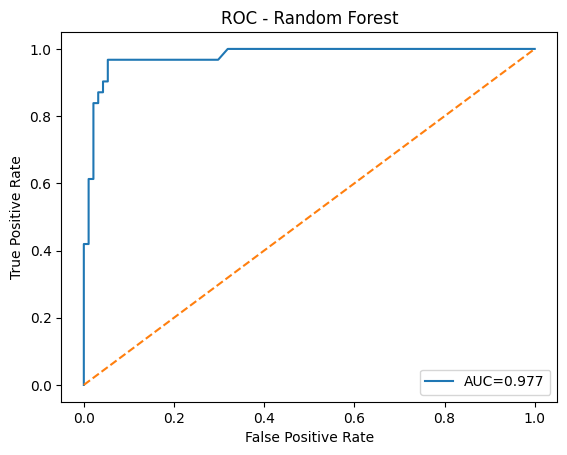

Mejor por AUC: RandomForest

=== Classification report (best) ===
              precision    recall  f1-score   support

           0       0.95      0.98      0.96        94
           1       0.93      0.84      0.88        31

    accuracy                           0.94       125
   macro avg       0.94      0.91      0.92       125
weighted avg       0.94      0.94      0.94       125



In [15]:
# ===================== 7) PLOTS =====================
# Matrices de confusión (1 figura por modelo)

def plot_cm(cm, title):
    # Convertir a porcentajes
    cm_percent = cm / cm.sum() * 100

    fig, ax = plt.subplots(figsize=(5, 4))
    im = ax.imshow(cm_percent, interpolation='nearest', cmap=plt.cm.Blues)

    # Colorbar
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

    # Etiquetas
    classes = ['Clase 0', 'Clase 1']
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    # Mostrar porcentajes en cada celda
    thresh = cm_percent.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm_percent[i, j]:.1f}%",
                    ha="center", va="center",
                    color="white" if cm_percent[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

plot_cm(dt_m["cm"], "Decision Tree - Matriz de Confusión (Test)")
plot_cm(rf_m["cm"], "Random Forest - Matriz de Confusión (Test)")

# Curvas ROC (una figura por modelo)
def plot_roc(roc_tuple, auc_val, title_prefix):
    fpr, tpr, _ = roc_tuple
    fig = plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={auc_val:.3f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC - {title_prefix}")
    plt.legend()
    plt.show()

plot_roc(dt_m["roc"], dt_m["auc"], "Decision Tree")
plot_roc(rf_m["roc"], rf_m["auc"], "Random Forest")

# (Opcional) Reporte del mejor modelo
best = rf_m if rf_m["auc"] >= dt_m["auc"] else dt_m
best_name = best["model"]
print(f"Mejor por AUC: {best_name}")
print("\n=== Classification report (best) ===")
best_pipe = rf if best_name == "RandomForest" else dt
print(classification_report(y_test, best_pipe.predict(X_test)))